In [63]:
import os
import cv2
import numpy as np
import sys

from scipy.optimize import minimize
import math


import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
tf.keras.backend.clear_session()

In [64]:
train_images = np.load('/Python/BDSL_THESIS/npy/train_image.npy')
train_labels = np.load('/Python/BDSL_THESIS/npy/train_label.npy')

test_images = np.load('/Python/BDSL_THESIS/npy/test_image.npy')
test_labels = np.load('/Python/BDSL_THESIS/npy/test_label.npy')

train_images = train_images / 255.0
test_images = test_images / 255.0

In [65]:
# from sklearn.model_selection import train_test_split

# # Split the data into train and test sets
# train_images, test_images, train_labels, test_labels = train_test_split(
#     x_images, y_labels, test_size=0.1, random_state=42)

In [66]:
# train_images, test_images, train_labels, test_labels = train_test_split(
#     x_images, y_labels, test_size=0.1, random_state=42)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# del x_images
# del y_labels

Train images shape: (6876, 32, 32, 3)
Train labels shape: (6876,)
Test images shape: (320, 32, 32, 3)
Test labels shape: (320,)


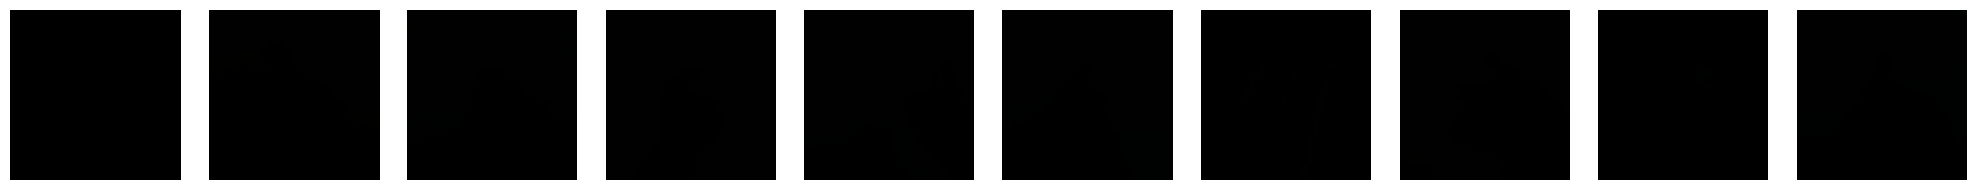

In [67]:
np.random.seed(42)

random_indices = np.random.choice(train_images.shape[0], size=10, replace=False)
fig = plt.figure(figsize=(20, 2))
for i, index in enumerate(random_indices):
    ax = fig.add_subplot(1, 10, i+1)
    #train_images[index] = cv2.cvtColor(train_images[index], cv2.COLOR_BGR2RGB)
    test = train_images[index] * 255
    ax.imshow(test.astype("uint8"))
    ax.axis('off')

fig.tight_layout()
plt.show()

In [68]:
print(train_images[0]*255)

[[[1.1186441  1.1242938  1.1129943 ]
  [1.0960453  1.101695   1.0903955 ]
  [1.0225989  1.0282485  1.0225989 ]
  ...
  [1.1186441  1.1242938  1.1073446 ]
  [1.0790961  1.0903955  1.0847458 ]
  [0.7627119  0.78531075 0.7966102 ]]

 [[1.1242938  1.1299435  1.1129943 ]
  [1.1186441  1.1242938  1.1129943 ]
  [1.1751412  1.1807909  1.158192  ]
  ...
  [1.1468927  1.1525424  1.1355932 ]
  [0.99435025 1.0112995  1.0056497 ]
  [0.7740113  0.7966102  0.80225986]]

 [[1.1807909  1.1751412  1.1638418 ]
  [1.1694915  1.1694915  1.1468927 ]
  [1.1751412  1.1751412  1.1525424 ]
  ...
  [1.0903955  1.101695   1.0903955 ]
  [0.84745765 0.8757062  0.8757062 ]
  [0.79096043 0.8079096  0.7966102 ]]

 ...

 [[0.7344633  0.7175141  0.70621467]
  [0.7627119  0.75706214 0.7344633 ]
  [0.779661   0.76836157 0.7457627 ]
  ...
  [0.29943502 0.40112993 0.5706215 ]
  [0.3220339  0.43502825 0.6158192 ]
  [0.33333334 0.44067797 0.6158192 ]]

 [[0.7344633  0.7344633  0.72316384]
  [0.7344633  0.740113   0.7288136 ]


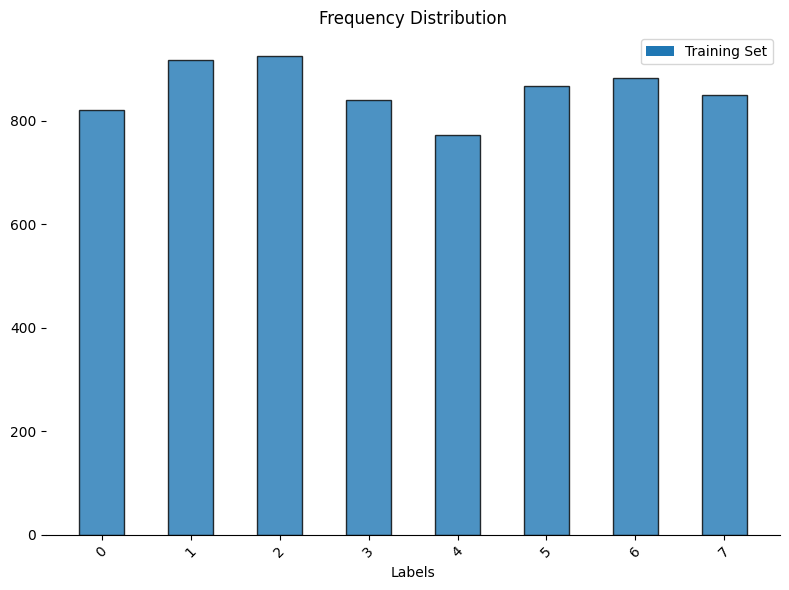

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy files
labels = train_labels
unique_labels, label_counts = np.unique(labels, return_counts=True)
fig, ax = plt.subplots(figsize=(8, 6))

bar_color = '#1f77b4' # Red color for the bars
bar_width = 0.5  # Width of the bars
bar_alpha = 0.8  # Transparency of the bars
bar_edgecolor = 'black'  # Edge color of the bars


bar_plot = ax.bar(unique_labels, label_counts, width=bar_width, color=bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
ax.set_xlabel('Labels')
ax.set_title('Frequency Distribution')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
custom_legend = [plt.Rectangle((0, 0), 1, 1, fc=bar_color)]
legend_labels = ['Training Set']
ax.legend(custom_legend, legend_labels)
fig.tight_layout()
plt.show()

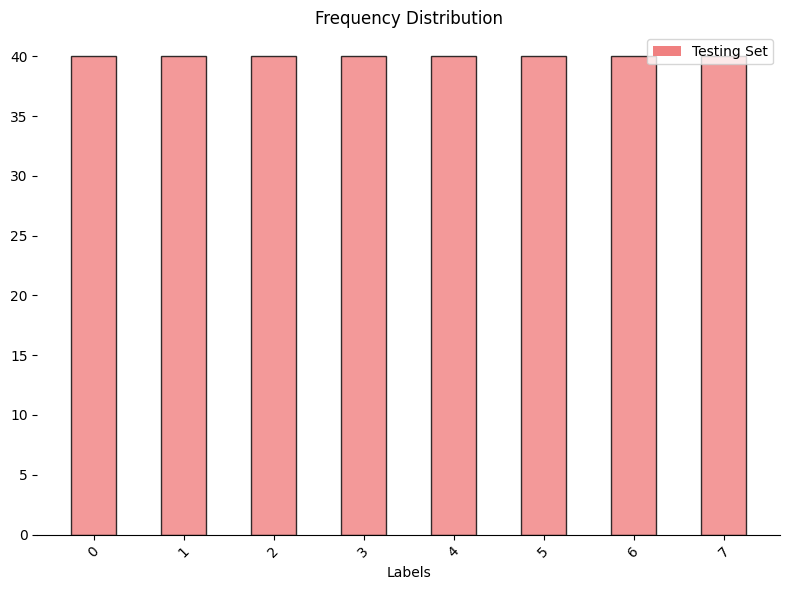

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy files
labels = test_labels

unique_labels, label_counts = np.unique(labels, return_counts=True)
fig, ax = plt.subplots(figsize=(8, 6))

bar_color = 'lightcoral' # Red color for the bars
bar_width = 0.5  # Width of the bars
bar_alpha = 0.8  # Transparency of the bars
bar_edgecolor = 'black'  # Edge color of the bars


bar_plot = ax.bar(unique_labels, label_counts, width=bar_width, color=bar_color, alpha=bar_alpha, edgecolor=bar_edgecolor)
ax.set_xlabel('Labels')
ax.set_title('Frequency Distribution')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
custom_legend = [plt.Rectangle((0, 0), 1, 1, fc=bar_color)]
legend_labels = ['Testing Set']
ax.legend(custom_legend, legend_labels)
fig.tight_layout()
plt.show()

## Probabilitstic Fitnet-4 classifier

In [71]:
from tensorflow import keras
num_classes = 8
num_class = num_classes 
train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes)
test_labels_one_hot = keras.utils.to_categorical(test_labels, num_classes)

In [72]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = train_images.shape[1:]

In [73]:
import tensorflow as tf

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
#     start_from_epoch=8
)

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1,min_lr=0.00000001, patience=5,),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
]

In [74]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes = 200
prototypes=200

num_class=num_classes

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)

flatten1=tf.keras.layers.Flatten()(dr3)

outputs = tf.keras.layers.Dense(num_class, activation='softmax')(flatten1)

model_p = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_p.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #lr=0.005
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_p.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 48)        13872     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 48)       192   

In [75]:
filepath = '/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina'#please define our own filepath to save the weights of the probabilistic FitNet-4 classifier
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)

model_p.fit(train_images, train_labels_one_hot, batch_size=25, epochs=200, verbose=1, callbacks=[checkpoint_callback], validation_data=(test_images, test_labels_one_hot), shuffle=True)

Epoch 1/200
276/276 [==============================] - ETA: 0s - loss: 3.0608 - accuracy: 0.1233
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
276/276 [==============================] - 7s 18ms/step - loss: 3.0608 - accuracy: 0.1233 - val_loss: 2.1560 - val_accuracy: 0.1250
Epoch 2/200
273/276 [============================>.] - ETA: 0s - loss: 2.3407 - accuracy: 0.1272
Epoch 2: val_accuracy improved from 0.12500 to 0.12812, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
276/276 [==============================] - 5s 17ms/step - loss: 2.3408 - accuracy: 0.1271 - val_loss: 2.1312 - val_accuracy: 0.1281
Epoch 3/200
274/276 [============================>.] - ETA: 0s - loss: 2.2189 - accuracy: 0.1222
Epoch 3: val_accuracy did not improve from 0.12812
276/276 [==============================] - 5s 17ms/step - loss: 2.2191 - accuracy: 0.

276/276 [==============================] - 5s 17ms/step - loss: 0.4035 - accuracy: 0.8586 - val_loss: 2.1740 - val_accuracy: 0.1562
Epoch 28/200
275/276 [============================>.] - ETA: 0s - loss: 0.3624 - accuracy: 0.8736
Epoch 28: val_accuracy did not improve from 0.79375
276/276 [==============================] - 5s 17ms/step - loss: 0.3634 - accuracy: 0.8735 - val_loss: 1.6580 - val_accuracy: 0.5094
Epoch 29/200
276/276 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8505
Epoch 29: val_accuracy did not improve from 0.79375
276/276 [==============================] - 5s 17ms/step - loss: 0.4070 - accuracy: 0.8505 - val_loss: 1.2544 - val_accuracy: 0.5969
Epoch 30/200
274/276 [============================>.] - ETA: 0s - loss: 0.3452 - accuracy: 0.8850
Epoch 30: val_accuracy did not improve from 0.79375
276/276 [==============================] - 5s 17ms/step - loss: 0.3464 - accuracy: 0.8848 - val_loss: 2.9583 - val_accuracy: 0.1250
Epoch 31/200
274/276 [

276/276 [==============================] - 4s 15ms/step - loss: 0.2368 - accuracy: 0.9223 - val_loss: 2.1048 - val_accuracy: 0.1594
Epoch 56/200
274/276 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9352
Epoch 56: val_accuracy did not improve from 0.91250
276/276 [==============================] - 4s 15ms/step - loss: 0.1908 - accuracy: 0.9350 - val_loss: 0.3653 - val_accuracy: 0.8813
Epoch 57/200
273/276 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9345
Epoch 57: val_accuracy did not improve from 0.91250
276/276 [==============================] - 4s 15ms/step - loss: 0.1956 - accuracy: 0.9344 - val_loss: 0.2871 - val_accuracy: 0.8844
Epoch 58/200
273/276 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9423
Epoch 58: val_accuracy did not improve from 0.91250
276/276 [==============================] - 4s 15ms/step - loss: 0.1752 - accuracy: 0.9421 - val_loss: 0.5391 - val_accuracy: 0.8438
Epoch 59/200
275/276 [

Epoch 84/200
274/276 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.9682
Epoch 84: val_accuracy did not improve from 0.92813
276/276 [==============================] - 5s 17ms/step - loss: 0.1001 - accuracy: 0.9682 - val_loss: 0.3157 - val_accuracy: 0.9031
Epoch 85/200
274/276 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9578
Epoch 85: val_accuracy improved from 0.92813 to 0.93437, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
276/276 [==============================] - 5s 17ms/step - loss: 0.1326 - accuracy: 0.9577 - val_loss: 0.2367 - val_accuracy: 0.9344
Epoch 86/200
275/276 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9660
Epoch 86: val_accuracy improved from 0.93437 to 0.93750, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
276/276 [==============================] - 5s 17ms/step - loss: 0.1102 - acc

276/276 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9801
Epoch 112: val_accuracy did not improve from 0.93750
276/276 [==============================] - 4s 15ms/step - loss: 0.0597 - accuracy: 0.9801 - val_loss: 0.2843 - val_accuracy: 0.9156
Epoch 113/200
273/276 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9792
Epoch 113: val_accuracy did not improve from 0.93750
276/276 [==============================] - 4s 15ms/step - loss: 0.0720 - accuracy: 0.9791 - val_loss: 0.6559 - val_accuracy: 0.8406
Epoch 114/200
274/276 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 0.9726
Epoch 114: val_accuracy improved from 0.93750 to 0.94063, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\cnn_checkpoint_fina
276/276 [==============================] - 4s 16ms/step - loss: 0.0927 - accuracy: 0.9724 - val_loss: 0.2272 - val_accuracy: 0.9406
Epoch 115/200
274/276 [============================>.] - 

274/276 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9815
Epoch 140: val_accuracy did not improve from 0.94687
276/276 [==============================] - 5s 17ms/step - loss: 0.0576 - accuracy: 0.9812 - val_loss: 0.3827 - val_accuracy: 0.9156
Epoch 141/200
276/276 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9825
Epoch 141: val_accuracy did not improve from 0.94687
276/276 [==============================] - 5s 17ms/step - loss: 0.0517 - accuracy: 0.9825 - val_loss: 0.3409 - val_accuracy: 0.9187
Epoch 142/200
275/276 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9827
Epoch 142: val_accuracy did not improve from 0.94687
276/276 [==============================] - 4s 16ms/step - loss: 0.0577 - accuracy: 0.9825 - val_loss: 0.7189 - val_accuracy: 0.8344
Epoch 143/200
274/276 [============================>.] - ETA: 0s - loss: 0.0483 - accuracy: 0.9853
Epoch 143: val_accuracy did not improve from 0.94687
276/276 [=

276/276 [==============================] - 4s 16ms/step - loss: 0.0512 - accuracy: 0.9849 - val_loss: 1.0410 - val_accuracy: 0.7063
Epoch 169/200
275/276 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.9821
Epoch 169: val_accuracy did not improve from 0.95938
276/276 [==============================] - 5s 16ms/step - loss: 0.0567 - accuracy: 0.9821 - val_loss: 1.0106 - val_accuracy: 0.7781
Epoch 170/200
275/276 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9917
Epoch 170: val_accuracy did not improve from 0.95938
276/276 [==============================] - 5s 17ms/step - loss: 0.0275 - accuracy: 0.9917 - val_loss: 0.3916 - val_accuracy: 0.8875
Epoch 171/200
273/276 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9884
Epoch 171: val_accuracy did not improve from 0.95938
276/276 [==============================] - 5s 16ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 1.7340 - val_accuracy: 0.5344
Epoch 172/200
27

276/276 [==============================] - 5s 16ms/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 0.4144 - val_accuracy: 0.8969
Epoch 198/200
276/276 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9898
Epoch 198: val_accuracy did not improve from 0.95938
276/276 [==============================] - 4s 15ms/step - loss: 0.0390 - accuracy: 0.9898 - val_loss: 0.3064 - val_accuracy: 0.9312
Epoch 199/200
275/276 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9879
Epoch 199: val_accuracy did not improve from 0.95938
276/276 [==============================] - 5s 17ms/step - loss: 0.0385 - accuracy: 0.9879 - val_loss: 2.4851 - val_accuracy: 0.3719
Epoch 200/200
275/276 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9936
Epoch 200: val_accuracy did not improve from 0.95938
276/276 [==============================] - 5s 16ms/step - loss: 0.0244 - accuracy: 0.9936 - val_loss: 0.3042 - val_accuracy: 0.9219


In [76]:
model_p.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina')
model_p.evaluate(train_images, train_labels_one_hot, batch_size=25, verbose=1)
model_p.evaluate(test_images, test_labels_one_hot, batch_size=25, verbose=1)

13/13 [==============================] - 0s 4ms/step - loss: 0.1874 - accuracy: 0.9594


[0.18741029500961304, 0.9593750238418579]

In [77]:
# Save model in HDF5 format (.h5)
model_p.save(filepath + 'model.h5')
tf.saved_model.save(model_p, filepath + 'saved_model/')


INFO:tensorflow:Assets written to: /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_finasaved_model/assets


INFO:tensorflow:Assets written to: /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_finasaved_model/assets


## Evidential - FitNet4

In [78]:
print(IMG_WIDTH)
print(IMG_HEIGHT)
print(num_class)
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
print(inputs_pixels)

32
32
8
1024


In [79]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes = 200
prototypes=200

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

ED = ds_layer.DS1(prototypes,128)(flatten1)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)


model_e = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_e.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 48)        13872     
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 48)       192 

H:\Python\Anaconda\envs\tensorflow-gpu\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [80]:
model_e.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina')
feature = tf.keras.Model(inputs=[inputs], outputs=[flatten1])
x_train_feature = feature.predict(train_images)
x_test_feature = feature.predict(test_images)

inputs = tf.keras.layers.Input(128)
ED = ds_layer.DS1(prototypes,128)(inputs)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)
model_mid = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_mid.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #0.001
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_mid.fit(x_train_feature, train_labels_one_hot, batch_size=25,  epochs=2, verbose=1, validation_data=(x_test_feature, test_labels_one_hot), shuffle=True)


model_e.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_fina')
DSLAYER_DS1_W = tf.reshape(model_mid.layers[1].get_weights()[0], [1, 200, 128])
DSLAYER_DS1_activate_W = model_mid.layers[2].get_weights()
DSLAYER_DS2_W = model_mid.layers[3].get_weights()
model_e.layers[26].set_weights(DSLAYER_DS1_W)
model_e.layers[27].set_weights(DSLAYER_DS1_activate_W)
model_e.layers[28].set_weights(DSLAYER_DS2_W)


filepath = '/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/evidential_DL_200_checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)
model_e.fit(train_images, train_labels_one_hot, batch_size=25,  epochs=3, verbose=1, callbacks=[checkpoint_callback], validation_data=(test_images, test_labels_one_hot), shuffle=True)

10/10 [==============================] - 0s 3ms/step
Epoch 1/2
276/276 [==============================] - 88s 165ms/step - loss: 2.0048 - accuracy: 0.2163 - val_loss: 1.8514 - val_accuracy: 0.3375
Epoch 2/2
276/276 [==============================] - 41s 148ms/step - loss: 1.3629 - accuracy: 0.4828 - val_loss: 1.0680 - val_accuracy: 0.5688
Epoch 1/3
276/276 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.4686
Epoch 1: val_accuracy improved from -inf to 0.36250, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\evidential_DL_200_checkpoint
276/276 [==============================] - 97s 185ms/step - loss: 1.2766 - accuracy: 0.4686 - val_loss: 2.2761 - val_accuracy: 0.3625
Epoch 2/3
276/276 [==============================] - ETA: 0s - loss: 1.0145 - accuracy: 0.5572
Epoch 2: val_accuracy improved from 0.36250 to 0.66250, saving model to /Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32\evidential_DL_200_checkpoint
276/276 

In [81]:
model_e.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/evidential_DL_200_checkpoint')
model_e.evaluate(train_images, train_labels_one_hot, batch_size=10, verbose=1)
model_e.evaluate(test_images, test_labels_one_hot, batch_size=10, verbose=1)

32/32 [==============================] - 1s 38ms/step - loss: 1.2119 - accuracy: 0.6625


[1.211879849433899, 0.6625000238418579]

In [82]:
num_class=num_classes
def func(x):
  fun=0
  for i in range(len(x)):
    fun += x[i] * math.log10(x[i])
  return fun

def cons1(x):
  return sum(x)

def cons2(x):
  tol = 0
  for i in range(len(x)):
    tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
  return tol

In [83]:
for j in range(2,(num_class+1)):
  num_weights = j
  ini_weights = np.asarray(np.random.rand(num_weights))

  name='weight'+str(j)
  locals()['weight'+str(j)]= np.zeros([5, j])

  for i in range(5):
    tol = 0.5 + i * 0.1

    cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
          {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
          {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
        )
  
    res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
    locals()['weight'+str(j)][i] = res.x
    print (res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.30102999566398114
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.5 0.5]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.29228525323862886
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.6 0.4]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2652949955741215
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.7 0.3]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.21732201127364892
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
[0.8 0.2]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1411817415046077
            Ite

In [84]:
def PowerSetsBinary(items):  
    N = len(items)   
    set_all=[]
    for i in range(2**N):
        combo = []  
        for j in range(N):  
            if(i >> j ) % 2 == 1:  
                combo.append(items[j]) 
        set_all.append(combo)
    return set_all

In [85]:
class_set=list(range(num_class))
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set)
print(act_set)
print(len(act_set))

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 7], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 4, 6, 7], [0, 1, 2, 3, 4, 7], [0, 1, 2, 3, 5], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 5, 6, 7], [0, 1, 2, 3, 5, 7], [0, 1, 2, 3, 6], [0, 1, 2, 3, 6, 7], [0, 1, 2, 3, 7], [0, 1, 2, 4], [0, 1, 2, 4, 5], [0, 1, 2, 4, 5, 6], [0, 1, 2, 4, 5, 6, 7], [0, 1, 2, 4, 5, 7], [0, 1, 2, 4, 6], [0, 1, 2, 4, 6, 7], [0, 1, 2, 4, 7], [0, 1, 2, 5], [0, 1, 2, 5, 6], [0, 1, 2, 5, 6, 7], [0, 1, 2, 5, 7], [0, 1, 2, 6], [0, 1, 2, 6, 7], [0, 1, 2, 7], [0, 1, 3], [0, 1, 3, 4], [0, 1, 3, 4, 5], [0, 1, 3, 4, 5, 6], [0, 1, 3, 4, 5, 6, 7], [0, 1, 3, 4, 5, 7], [0, 1, 3, 4, 6], [0, 1, 3, 4, 6, 7], [0, 1, 3, 4, 7], [0, 1, 3, 5], [0, 1, 3, 5, 6], [0, 1, 3, 5, 6, 7], [0, 1, 3, 5, 7], [0, 1, 3, 6], [0, 1, 3, 6, 7], [0, 1, 3, 7], [0, 1, 4], [0, 1, 4, 5], [0, 1, 4, 5, 6], [0, 1, 4, 5, 6, 7], [0, 1, 4, 5, 7], [0, 1, 4, 6], [0, 1, 4, 6, 7], [0, 1, 4, 7]

In [86]:
utility_matrix = np.zeros([len(act_set), len(class_set)])
tol_i = 3 
for i in range(len(act_set)):
  intersec = class_set and act_set[i]
  if len(intersec) == 1:
    utility_matrix[i, intersec] = 1
  
  else:
    for j in range(len(intersec)):
      utility_matrix[i, intersec[j]] = locals()['weight'+str(len(intersec))][tol_i, 0]
print (utility_matrix)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.8        0.8        0.         ... 0.         0.         0.        ]
 [0.68186243 0.68186243 0.68186243 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.8        0.8       ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [87]:
prototypes=200
number_act_set = len(act_set)

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

#DS layer
ED = ds_layer.DS1(prototypes,128)(flatten1)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

#Utility layer for testing
outputs = utility_layer_test.DM_test(num_class, number_act_set, 0.9)(mass_Dempster_normalize)


model_e_imprecise = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e_imprecise.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_e_imprecise.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 48)        13872     
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 48)        20784     
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 48)       192 

In [90]:
model_e_imprecise.layers[-1].set_weights(tf.reshape(utility_matrix, [1, 255, 8]))
model_e_imprecise.load_weights('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/evidential_DL_200_checkpoint')

In [91]:
resutls = tf.argmax(model_e_imprecise.predict(test_images),-1)
imprecise_results =[]
for i in range(len(resutls)):
  act_local = resutls[i]
  set_valued_results = act_set[act_local]
  imprecise_results.append(set_valued_results)
print (imprecise_results)
average_utility_imprecision = AU_imprecision.average_utility(utility_matrix, resutls, test_labels, act_set)
print (average_utility_imprecision)

10/10 [==============================] - 12s 74ms/step
[[0, 3, 4], [0, 3, 4], [5, 6], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [5], [0, 3, 4], [2, 3, 6, 7], [0, 3, 4], [0, 3, 4], [5, 6], [5, 6], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0, 3, 4], [0], [0, 3, 4], [0, 3, 4], [5], [5, 6], [5], [5], [6], [0, 3, 4], [1], [0, 5], [5], [1], [1], [1], [1], [0, 3, 4], [1], [0, 3, 4], [1], [1], [1], [5, 6], [1], [1], [1], [1], [1], [1], [0, 3, 4], [0, 3, 4], [1], [1], [1], [1], [1], [1], [1], [1], [0, 3, 4], [1], [1], [1], [0, 5], [0, 3, 4], [5], [1], [0, 3, 4], [1], [2, 7], [2, 3, 6, 7], [2, 6, 7], [2, 3, 6, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 3, 6, 7], [2, 3, 6, 7], [0, 3], [2, 7], [2, 7], [2, 7], [2, 7], [2, 3, 6, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [

1/1 [==============================] - 0s 121ms/step
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 48)
(1, 32, 32, 48)
(1, 32, 32, 48)
(1, 16, 16, 48)
(1, 16, 16, 48)
(1, 16, 16, 80)
(1, 16, 16, 80)
(1, 16, 16, 80)
(1, 16, 16, 80)
(1, 16, 16, 80)
(1, 16, 16, 80)
(1, 8, 8, 80)
(1, 8, 8, 80)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 1, 1, 128)
(1, 1, 1, 128)
(1, 128)
(1, 8)


H:\Python\Anaconda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


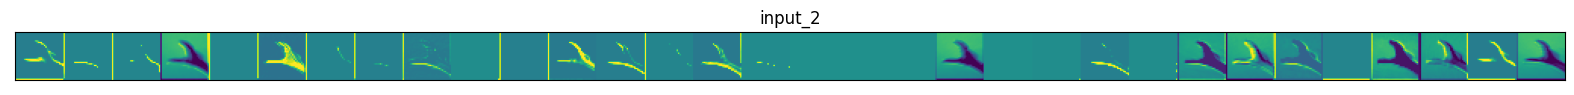

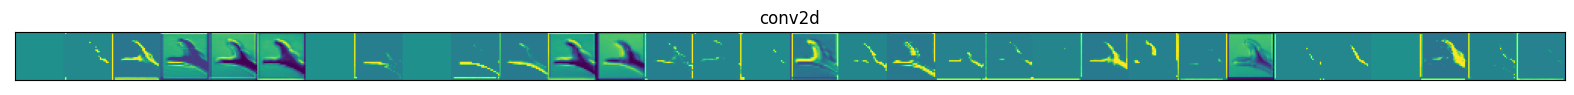

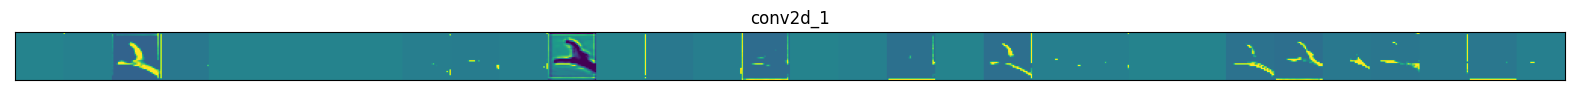

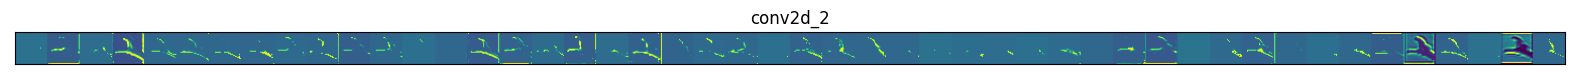

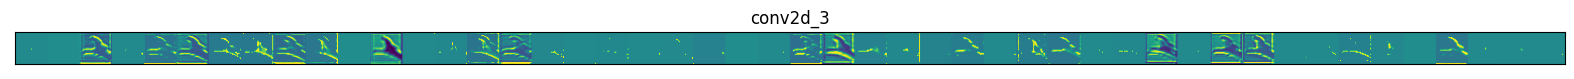

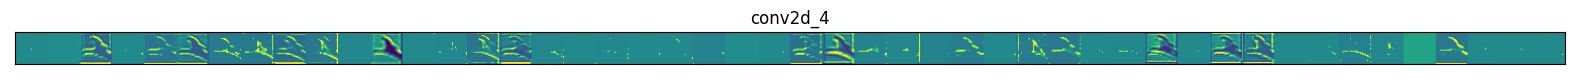

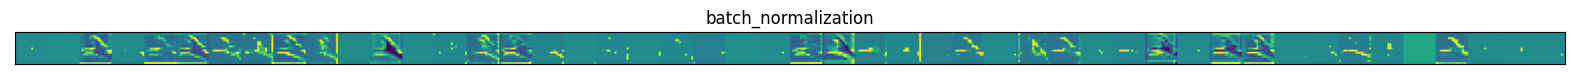

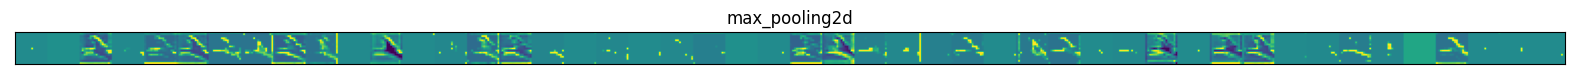

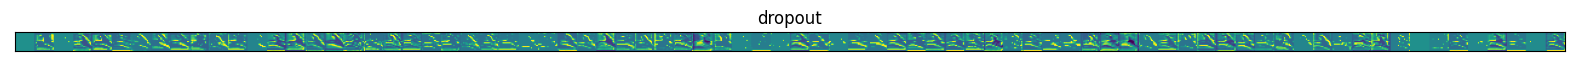

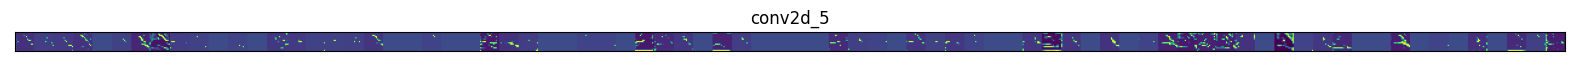

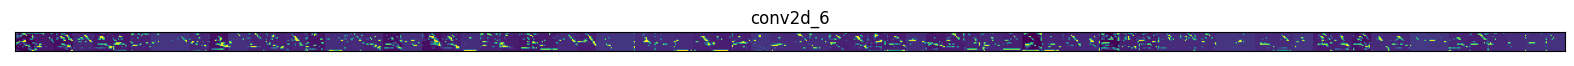

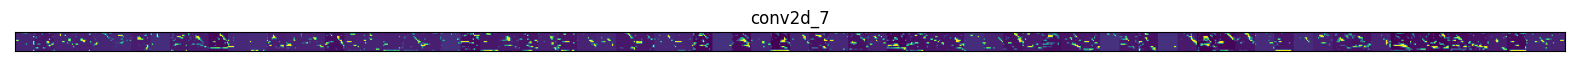

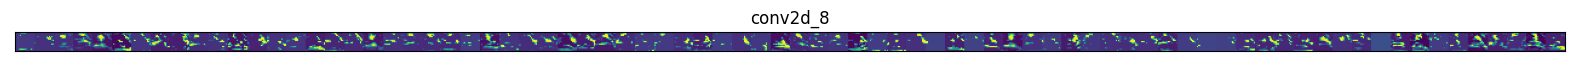

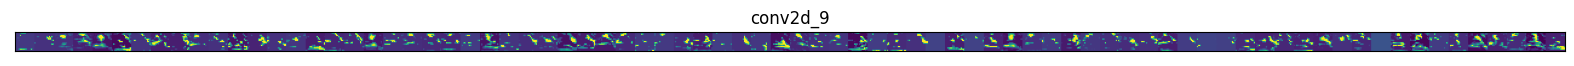

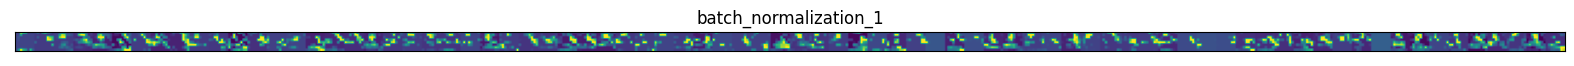

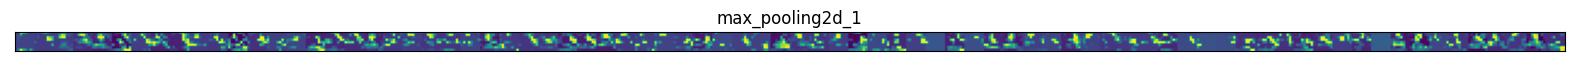

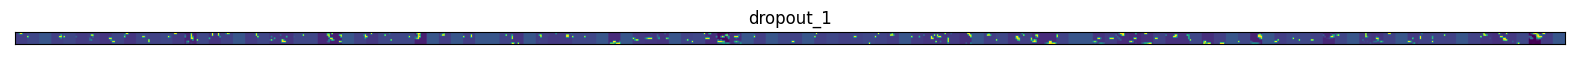

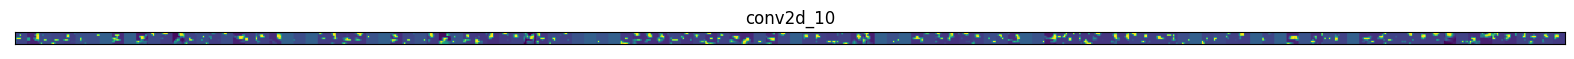

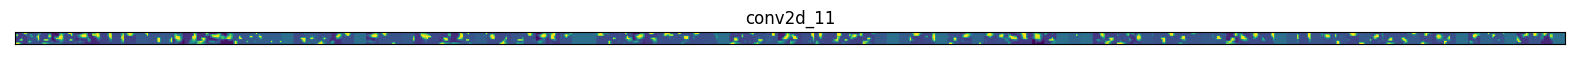

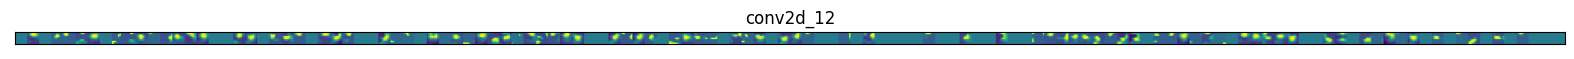

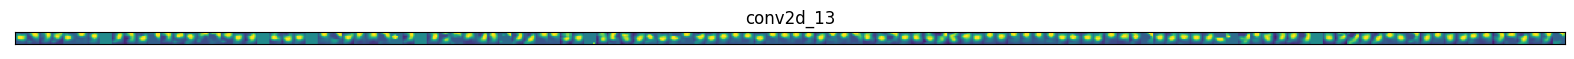

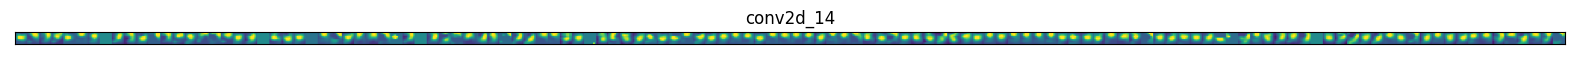

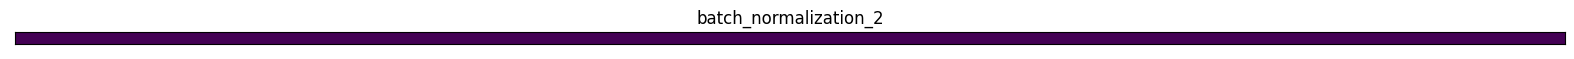

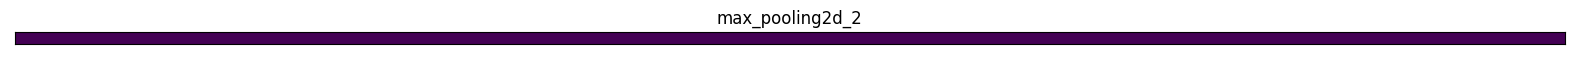

In [96]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = tf.keras.models.load_model('/Python/BDSL49/Recognition_Processed_Compressed/DatasetNPY32x32/cnn_checkpoint_finamodel.h5')


successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)


# img_path = '/Python/HAM1000/HAM10000_images/ISIC_0024339.jpg'  # Replace with the path to your image
# img = load_img(img_path, target_size=(32, 32))
img = test_images[0]

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x_min = np.min(x)
x_max = np.max(x)
x = (x - x_min) / (x_max - x_min)
successive_feature_maps = visualization_model.predict(x)


layer_names = [layer.name for layer in model.layers]


for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  
        size = feature_map.shape[1] 
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            std = x.std()
            epsilon = 1e-8  # Small epsilon value to avoid division by zero
            x /= (std + epsilon)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')


            display_grid[:, i * size: (i + 1) * size] = x


        scale = 20.0 / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()


In [93]:
print(model_e.layers[11])
print(model_e.layers[12])
print(model_e.layers[13])

In [20]:
# IMG_WIDTH = 32
# IMG_HEIGHT = 32
# IMG_CHANNELS = 3
# inputs_pixels = IMG_WIDTH * IMG_HEIGHT
# prototypes=200
# num_class=10

# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# #convolution stages
# c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
# c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
# c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
# c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
# c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
# bt1 = tf.keras.layers.BatchNormalization()(c1_5)
# p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
# dr1 = tf.keras.layers.Dropout(0.5)(p1)


# c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
# c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
# c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
# c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
# c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
# bt2 = tf.keras.layers.BatchNormalization()(c2_5)
# p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
# dr2 = tf.keras.layers.Dropout(0.5)(p2)

# c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
# c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
# c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
# c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
# c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
# bt3 = tf.keras.layers.BatchNormalization()(c3_5)
# p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
# dr3 = tf.keras.layers.Dropout(0.5)(p3)
# flatten1=tf.keras.layers.Flatten()(dr3)

# #DS layer
# ED = ds_layer.DS1(prototypes,128)(flatten1)
# ED_ac = ds_layer.DS1_activate(prototypes)(ED)
# mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
# mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
# mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
# mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

# #Utility layer for training
# outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)


# model_e = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model_e.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
#               loss='CategoricalCrossentropy',
#               metrics=['accuracy'])

# print(model_e.layers[1])
# print(model_e.layers[2])
# print(model_e.layers[3])
# print(model_e.layers[26])
# print(model_e.layers[27])
# print(model_e.layers[28])

In [28]:
#mine 
print(model_e.layers[1])
print(model_e.layers[2])
print(model_e.layers[3])
print(model_e.layers[34])
print(model_e.layers[35])
print(model_e.layers[36])